The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Enter your coordinate filename (ex: DMEP.3): DMEP.3

    File name is DMEP.3 - Specify at least 2 bonds you want to assess: 
    C1-O4, C1-H8 , C1-H9 , C1-H10, 
    C2-O6, C2-H14, C2-H15, C2-H16,
    C3-P7, C3-H11, C3-H12, C3-H13,
    P7-O4, P7-O5 , P7-O6 
    Type "all" to see all bonds.
    
Bond name: P7-O6
Bond name: C1-H10
Bond name: 
Bonds entered are : [('P7', 'O6'), ('C1', 'H10')]


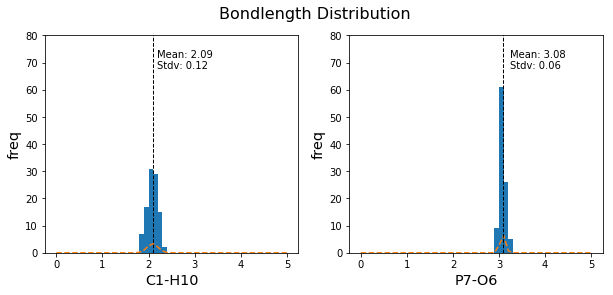

In [27]:
# autoreload to cast any changes to the module files into the notebook
%load_ext autoreload
%autoreload 2
import re, math, os, csv, timeit
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import table
from IPython.display import display
from matplotlib.ticker import EngFormatter
from matplotlib.ticker import MultipleLocator
from datetime import date 

# # --------------------------- Preprocess Data -------------------------

def get_lines_with_coordinates(file_name):
    ''' take in xyz file & grab lines with coordinates
        Input: fileName
        Output: a list of lines with coordinates
    '''
    searchfile = open(file_name, "r",encoding='utf-8')
    line_list = searchfile.readlines()
    return line_list


def split_into_trajectory_blocks(line_list):
    ''' convert file line_list into trajectory_blocks
        Input: line_list
        Output: a list, trajectory_blocks
    '''
    trajectory_blocks = []
    for index, line in enumerate(line_list):
        if re.search(r'Geometry', line):
            # create new block for each trajectory
            trajectory_coordinates = get_trajectory_data(index,line_list)

            # append to list
            trajectory_blocks.append(trajectory_coordinates)            
    return trajectory_blocks


def get_trajectory_data(index, line_list):
    ''' read a trajetory --> if(match regex | EOF), return 
        Input: index, list_of_lines_in_file
        Output: a list coordinates for that block, first item= TRAJ#, remaining items np_arrays 
                each coordinate is in format [float(x), float(y), float(z)]
    '''
    trajectory_coordinates = [line_list[index][:-1]] # grab trajectory #
    for line in line_list[index+1:]:
        if (re.search(r'Velocity', line)):
            break
        else:
            atom,Z,x,y,z,A = line.split()
            trajectory_coordinates.append(np.asarray([float(x), float(y), float(z)], dtype=np.float64)) 
    return trajectory_coordinates 

def preprocess_data(file_name):    
    ''' Input: filename
        Output: a list of trajectory_blocks_in_file, 
                each block representing 1 trajectory
    '''
    line_list = get_lines_with_coordinates(file_name)
    traj_blocks_in_file = split_into_trajectory_blocks(line_list)
    return traj_blocks_in_file   


# --------------------------- Perform Computation -------------------------
def compute(block, input_bonds):
    ''' compute geometric params for each traj (bondlength, C_C_C angles, dihedrals H9-C6-C7-H10 and H11-C8-C1-H12.
        Input: a list of np_array, representing data for 1 traj
        Output:a dictionary, , representing data for 1 traj
        format : "TRAJ : 1, C1-C2: (double), C2-C3 (double), ... "
    '''    
    dictionary_for_trajectory = {}
    for bond in input_bonds:
        atom1,atom2 = bond
        atom1 = int(re.findall('\d+', atom1)[0])
        atom2 = int(re.findall('\d+', atom2)[0])
        bond = '-'.join(map(str, bond))
        dictionary_for_trajectory[bond] = np.linalg.norm(block[atom1] - block[atom2])    
    return dictionary_for_trajectory  


def compute_geometric_params(input_file, input_bonds, *args):
    ''' extract from xyz, compute, write to csv
        Input: input_file
        Output: csv
        
        ### While plotting histrograms - 2 items to change: ###
        1. range(lower,upper)
        2. output name (file + folder)
    '''
    # --------------------------- Preprocess Data -------------------------
    list_of_blocks_in_file = preprocess_data(input_file)
    # --------------------------- Perform Computation -------------------------
    list_of_traj_dictionaries = []
    for block in list_of_blocks_in_file:

        # compute(block)
        dictionary_for_trajectory = compute(block, input_bonds)

        # create new entries in list_of_dictionaries "Traj : 1, C1-C2: (double), C2-C3 (double), ... "
        list_of_traj_dictionaries.append(dictionary_for_trajectory)

    # ---------------------------- Convert to data frame & visualize -----------------------
    traj_df = pd.DataFrame.from_dict(list_of_traj_dictionaries)
    lower=0
    upper=5
    
    fig_x = len(input_bonds)*5
    fig, axes = plt.subplots(ncols=len(traj_df.columns), figsize=(fig_x,4))
    fig.suptitle('Bondlength Distribution', size=16) 
    
    for col, ax in zip(traj_df.columns, axes):
            x = traj_df[col]
            n, bins, patches = ax.hist(x, bins=50, range=(lower,upper), histtype='stepfilled')
            best_fit = (1 / (np.sqrt(2 * np.pi) * x.std())) * np.exp(-0.5 * (1 / x.std() * (bins - x.mean()))**2)
            # ax.hist(x, bins=50, range=(0,5), histtype='stepfilled')
            ax.plot(bins, best_fit, '--')            
            ax.set_xlabel(col, fontsize='x-large')
            ax.set_ylabel('freq', fontsize='x-large')
            ax.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
            ax.set_ybound(lower=0,upper=80)
            ymin,ymax=ax.get_ylim()
            ax.text(x.mean()*1.05, ymax*0.9,'Mean: {:.2f}'.format(x.mean()))
            ax.text(x.mean()*1.05, ymax*0.85,'Stdv: {:.2f}'.format(x.std()))

    #------------------------- Output to file ----------------------#
    output_path = os.path.join(".", "visuals","DMEP", "histograms", "_DMEP_bondlength_distribution" + ".png")
    os.makedirs(os.path.dirname(output_path), exist_ok=True) # create 'visuals' & 'histograms' folder if not existed yet
    plt.savefig(output_path)
 
    # --------------------------- Write to csv ---------------------------
    date_computed = str(date.today())
    file_path = os.path.join(".", "output", "DMEP",date_computed + "_DMEP_bonds" + ".csv")
    os.makedirs(os.path.dirname(file_path), exist_ok=True) # create 'output' folder if not existed yet

    with open(file_path, 'w', newline='', encoding='utf-8') as csvFile:
        field_names = list(list_of_traj_dictionaries[0].keys())
        writer = csv.DictWriter(csvFile, fieldnames=field_names, dialect='excel')

        writer.writeheader()
        for trajectory in list_of_traj_dictionaries:
            writer.writerow(trajectory)
            
            
def take_user_input():            
    ''' ask for user input
        Input: None
        Output: input_file & list of input_bonds
    '''
    file_name = input("Enter your coordinate filename (ex: DMEP.3): ")
    s = '''
    File name is {} - Specify at least 2 bonds you want to assess: 
    C1-O4, C1-H8 , C1-H9 , C1-H10, 
    C2-O6, C2-H14, C2-H15, C2-H16,
    C3-P7, C3-H11, C3-H12, C3-H13,
    P7-O4, P7-O5 , P7-O6 
    Type "all" to see all bonds.
    '''.format(file_name)
    print(s)
    
    valid_bonds = [ ('C1','O4'), ('C1','H8'), ('C1','H9') , ('C1','H10'),
                    ('C2','O6'), ('C2','H14'), ('C2','H15'), ('C2','H16'),
                    ('C3','P7'), ('C3','H11'), ('C3','H12'), ('C3','H13'),
                    ('P7','O4'), ('P7','O5') , ('P7','O6') ]
    input_bonds = []
    bond_name = input("Bond name: ")    
    if bond_name == '':
        print("Invalid. Bond name format: <atom>#-<atom>#.") 
        return
    while bond_name != "":
        if bond_name == 'all':
            input_bonds = valid_bonds
            break
        else:
            bond_name = re.sub(r'[ ;,\t)(&!_^%$#!~@,+,./\|}{]', '',bond_name)
            input_bonds.append(tuple(re.split('[-=]', bond_name)))
            bond_name = input("Bond name: ")
    print("Bonds entered are : {}".format(str(input_bonds)))
    return file_name,input_bonds



# --------------------- Main program ------------------------
def main():
    file_name, input_bonds = take_user_input()
    compute_geometric_params(file_name,input_bonds)
    
main()

In [ ]:
'''
Reference: https://matplotlib.org/3.1.1/gallery/statistics/histogram_features.html
'''